In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('optum_withencounter.csv')

In [4]:
# drop first column created while saving
df = df.drop(df.columns[0], axis= 1)

In [6]:
df.head(1)

,PATIENT,ALLERGIES_CODE,GENDER,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,CAREPLANS_CODE,CONDITIONS_CODE,DEVICES_CODE,BODYSITE_CODE,MODALITY_CODE,SOP_CODE,IMMUN_CODE,IMMUN_BASE_COST,PAYER_x,MEDICATION_CODE,MEDICATION_BASECOST,MEDICATION_PAYERCOVERAGE,DISPENSES,MEDICATION_TOTALCOST,MEDICATION_REASONCODE,OBSERVATION_CODE,OBSERVATION_VALUE,OBSERVATION_UNITS,PROCEDURE_CODE,BASE_COST_PROCEDURE,REASONCODE_PROCEDURE,Id,START,STOP,ORGANIZATION,PROVIDER,PAYER_y,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,76982e06-f8b8-4509-9ca3-65a99c8650fe,300916003.0,F,Boston,Massachusetts,Suffolk County,779464.29,11713.81,195662009.0,195662009.0,NaN,NaN,NaN,NaN,140.0,140.52,d47b3510-2895-3b70-9897-342d681c769d,1049630.0,10.23,0.0,456.0,4664.88,NaN,8310-5,37.1,Cel,117015009.0,2405.38,195662009.0,b896bf40-8b72-42b7-b205-142ee3a56b55,1982-10-25T18:19:08Z,1982-10-25T18:55:08Z,db0acede-4abe-3c01-8d03-5c68a190d8c7,5bf929a6-ea58-3e94-a4cf-22cc1e168d6d,d47b3510-2895-3b70-9897-342d681c769d,ambulatory,185347001.0,Encounter for problem,129.16,129.16,49.16,NaN,NaN


In [11]:
# unique value columns
unique_value_cols = []
for col in df.columns:
  if len(df[col].unique())/len(df) == 1:
    unique_value_cols.append(col)
print(unique_value_cols)

['Id']


In [14]:
# Remove columns with more than 30% null values
to_drop = []
for col in df.columns:
  if df[col].isnull().sum()/len(df) > 0.3:
    to_drop.append(col)
print(to_drop)

['DEVICES_CODE', 'BODYSITE_CODE', 'MODALITY_CODE', 'SOP_CODE', 'MEDICATION_REASONCODE', 'REASONCODE_PROCEDURE', 'REASONCODE', 'REASONDESCRIPTION']


In [15]:
# Drop columns
df = df.drop(to_drop, axis= 1)

In [18]:
df.head(1)

,PATIENT,ALLERGIES_CODE,GENDER,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,CAREPLANS_CODE,CONDITIONS_CODE,IMMUN_CODE,IMMUN_BASE_COST,PAYER_x,MEDICATION_CODE,MEDICATION_BASECOST,MEDICATION_PAYERCOVERAGE,DISPENSES,MEDICATION_TOTALCOST,OBSERVATION_CODE,OBSERVATION_VALUE,OBSERVATION_UNITS,PROCEDURE_CODE,BASE_COST_PROCEDURE,Id,START,STOP,ORGANIZATION,PROVIDER,PAYER_y,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE
0,76982e06-f8b8-4509-9ca3-65a99c8650fe,300916003.0,F,Boston,Massachusetts,Suffolk County,779464.29,11713.81,195662009.0,195662009.0,140.0,140.52,d47b3510-2895-3b70-9897-342d681c769d,1049630.0,10.23,0.0,456.0,4664.88,8310-5,37.1,Cel,117015009.0,2405.38,b896bf40-8b72-42b7-b205-142ee3a56b55,1982-10-25T18:19:08Z,1982-10-25T18:55:08Z,db0acede-4abe-3c01-8d03-5c68a190d8c7,5bf929a6-ea58-3e94-a4cf-22cc1e168d6d,d47b3510-2895-3b70-9897-342d681c769d,ambulatory,185347001.0,Encounter for problem,129.16,129.16,49.16


In [21]:
# change dates to durations
# first convert them into date type
print(df['STOP'].dtype)
df['START'] = pd.to_datetime(df['START'])
df['STOP'] = pd.to_datetime(df['STOP'])
df['STOP'].dtype

object


datetime64[ns, UTC]

In [23]:
df['DURATION'] = df['STOP'] - df['START']
df['DURATION'].head()

0   0 days 00:36:00
1   0 days 01:28:00
2   0 days 00:38:00
3   0 days 00:30:00
4   0 days 00:15:00
Name: DURATION, dtype: timedelta64[ns]

In [34]:
# Extract machine readable features from duration
#df['MONTHS'] = df['DURATION'].dt.months
df['DAYS'] = df['DURATION'].dt.days
df['HOURS'] = (df['DURATION']/pd.Timedelta('1 hour')).astype('int8')
display(df[['DAYS', 'HOURS']].head())

,DAYS,HOURS
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0


In [ ]:
# Drop redundant columns
to_drop = ['STOP', 'START', 'DURATION']
df = df.drop(to_drop, axis= 1)

In [36]:
df.head(1)

,PATIENT,ALLERGIES_CODE,GENDER,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,CAREPLANS_CODE,CONDITIONS_CODE,IMMUN_CODE,IMMUN_BASE_COST,PAYER_x,MEDICATION_CODE,MEDICATION_BASECOST,MEDICATION_PAYERCOVERAGE,DISPENSES,MEDICATION_TOTALCOST,OBSERVATION_CODE,OBSERVATION_VALUE,OBSERVATION_UNITS,PROCEDURE_CODE,BASE_COST_PROCEDURE,Id,ORGANIZATION,PROVIDER,PAYER_y,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,DAYS,HOURS
0,76982e06-f8b8-4509-9ca3-65a99c8650fe,300916003.0,F,Boston,Massachusetts,Suffolk County,779464.29,11713.81,195662009.0,195662009.0,140.0,140.52,d47b3510-2895-3b70-9897-342d681c769d,1049630.0,10.23,0.0,456.0,4664.88,8310-5,37.1,Cel,117015009.0,2405.38,b896bf40-8b72-42b7-b205-142ee3a56b55,db0acede-4abe-3c01-8d03-5c68a190d8c7,5bf929a6-ea58-3e94-a4cf-22cc1e168d6d,d47b3510-2895-3b70-9897-342d681c769d,ambulatory,185347001.0,Encounter for problem,129.16,129.16,49.16,0,0


In [37]:
# remove columns that plays no intuitive role in calculation healthcare_expense
to_drop = ['PAYER_x', 'PAYER_y', 'DESCRIPTION']
df = df.drop(to_drop, axis= 1)

In [38]:
df.head(1)

,PATIENT,ALLERGIES_CODE,GENDER,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,CAREPLANS_CODE,CONDITIONS_CODE,IMMUN_CODE,IMMUN_BASE_COST,MEDICATION_CODE,MEDICATION_BASECOST,MEDICATION_PAYERCOVERAGE,DISPENSES,MEDICATION_TOTALCOST,OBSERVATION_CODE,OBSERVATION_VALUE,OBSERVATION_UNITS,PROCEDURE_CODE,BASE_COST_PROCEDURE,Id,ORGANIZATION,PROVIDER,ENCOUNTERCLASS,CODE,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,DAYS,HOURS
0,76982e06-f8b8-4509-9ca3-65a99c8650fe,300916003.0,F,Boston,Massachusetts,Suffolk County,779464.29,11713.81,195662009.0,195662009.0,140.0,140.52,1049630.0,10.23,0.0,456.0,4664.88,8310-5,37.1,Cel,117015009.0,2405.38,b896bf40-8b72-42b7-b205-142ee3a56b55,db0acede-4abe-3c01-8d03-5c68a190d8c7,5bf929a6-ea58-3e94-a4cf-22cc1e168d6d,ambulatory,185347001.0,129.16,129.16,49.16,0,0


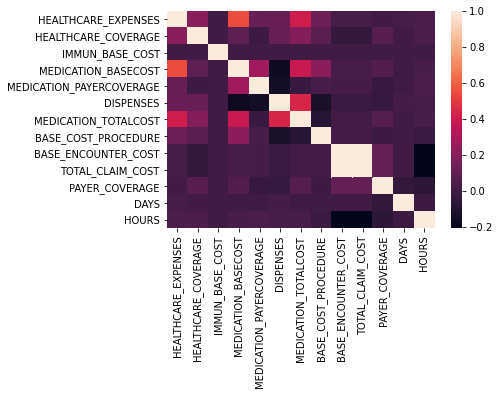

In [44]:
# check correlation
numeric_cols = ['HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'IMMUN_BASE_COST', 'MEDICATION_BASECOST', 'MEDICATION_PAYERCOVERAGE', 'DISPENSES', 'MEDICATION_TOTALCOST', 'BASE_COST_PROCEDURE', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'DAYS', 'HOURS']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix)

In [64]:
# categorical columns
cat_cols = ['ALLERGIES_CODE', 'GENDER', 'CITY', 'STATE', 'COUNTY', 'CAREPLANS_CODE', 'CONDITIONS_CODE', 'IMMUN_CODE', 'MEDICATION_CODE', 'OBSERVATION_CODE', 'OBSERVATION_UNITS', 'PROCEDURE_CODE', 'ORGANIZATION', 'PROVIDER', 'ENCOUNTERCLASS', 'CODE', 'OBSERVATION_VALUE']
for col in cat_cols:
  unique_values_perc = len(df[col].unique())
  print('Unique values in %s:'%(col), unique_values_perc)

Unique values in ALLERGIES_CODE: 16
Unique values in GENDER: 2
Unique values in CITY: 97
Unique values in COUNTY: 13
Unique values in CAREPLANS_CODE: 32
Unique values in CONDITIONS_CODE: 32
Unique values in IMMUN_CODE: 9
Unique values in MEDICATION_CODE: 32
Unique values in OBSERVATION_CODE: 8
Unique values in OBSERVATION_UNITS: 8
Unique values in PROCEDURE_CODE: 24
Unique values in ORGANIZATION: 239
Unique values in PROVIDER: 240
Unique values in ENCOUNTERCLASS: 7
Unique values in CODE: 36
Unique values in OBSERVATION_VALUE: 140


In [48]:
# Remove state 
df = df.drop(['STATE'], axis= 1)

In [49]:
# Encode categorical values
for col in cat_cols:
  if col != 'STATE':
    df[col], _  = pd.factorize(df[col])

In [ ]:
df.head()

# Model Building

In [88]:
# remove rows with null values
df = df.dropna(axis= 0)

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Try only with numeric columns
df_nemric = df[numeric_cols]
X_numeric = scaler.fit_transform(df_nemric.drop(['HEALTHCARE_EXPENSES'], axis= 1))
y_numeric = df_nemric['HEALTHCARE_EXPENSES']

In [89]:
#X = df.drop(['PATIENT', 'HEALTHCARE_EXPENSES', 'Id', 'OBSERVATION_VALUE'], axis= 1).dropna(axis= 0)
#y = df[['HEALTHCARE_EXPENSES']]

In [99]:
# model testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import RandomizedSearchCV


# model validation function
def MV(model, param_dict, features= X_numeric, target= y_numeric):
    rscv = RandomizedSearchCV(model, param_distributions= param_dict, n_iter= 25, cv= 5, random_state= 40,\
                              n_jobs= -1, return_train_score= True)
    
    rscv.fit(features, target)
    
    print("Cross-validated train scores:", rscv.cv_results_['mean_train_score'][0:6])
    
    print("Cross-validated test scores:", rscv.cv_results_['mean_test_score'][:6])
    
    print("Best test score:{:.2f}".format(rscv.best_score_))

In [102]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor(random_state= 20)

param_dict_rfc = {
    'n_estimators': np.arange(2, 1000, 1),
    'max_depth': np.arange(5, 50, 1),
    "min_samples_leaf": np.arange(0.001, 0.8, 0.001),
    "max_features": np.arange(1, 11, 1)
}

MV(rfc, param_dict= param_dict_rfc)

Cross-validated train scores: [ 7.54062487e-01  1.11762410e-01  4.19810545e-01 -2.22162196e-07
  5.26883498e-01             nan]
Cross-validated test scores: [ 0.49711577  0.0024122   0.2697137  -0.0952582   0.31685835         nan]
Best test score:0.50


In [103]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

gbc = GradientBoostingRegressor(random_state= 20)

param_dict_gbc = {
    'n_estimators': np.arange(1, 500, 10),
    'max_depth': np.arange(3, 50, 1),
    'min_samples_leaf': np.arange(0.001, 0.2, 0.001),
    'subsample': np.arange(0.1, 1.1, 0.1)
}

MV(gbc, param_dict= param_dict_gbc)

Cross-validated train scores: [ 7.59280904e-01  5.33234358e-01 -3.40577497e-05  5.63535778e-01
  7.38088244e-01  8.78687101e-01]
Cross-validated test scores: [ 0.3169181   0.20486746 -0.0979425   0.44818392  0.50073027  0.49872786]
Best test score:0.51


In [104]:
import xgboost as xgb

xgb_clf = xgb.XGBRegressor(objective= 'reg:linear')

param_dict_xgb = {
    'eta': np.arange(0.1, 1, 0.1),
    'gamma': np.arange(0, 100, 1),
    'max_depth': np.arange(1, 20, 1),
    'subsample': np.arange(0.05, 1, 0.05),
    'colsample_bytree': np.arange(0.1, 1, 0.1)
}

MV(xgb_clf, param_dict= param_dict_xgb)

[17:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Cross-validated train scores: [0.99984636 0.99998997 0.99999994 0.99901747 0.99984041 0.90820654]
Cross-validated test scores: [0.16474891 0.1564313  0.2807755  0.10612366 0.21148102 0.32409574]
Best test score:0.39
